# Introducing the Neural Networks

In this notebook I'll use a simple Neural Network in TensorFlow to classify the clients of a bank as two classes:

- Will open a deposit
- Will not open a deposit


**SPOILER:** The dataset is imbalanced, as it is the same dataset I've used to make a notebook addressing this problem. However, what counts is that the Neural Network is implemented and the results make sense (taking into account the imbalance in the data).

# Preprocessing the data

Now, the content up until the neural network will be incredibly similar to the imbalanced data, since I'm downloading the data and converting the categorical data into numerical, one-hot encoding the columns that had multiple categories.

In [1]:
#importing data and data wrangling
from sklearn import datasets
import pandas as pd

#Linear Algebra
import numpy as np

#Statistics
import scipy as sp

#Visualizations
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
#Downloading dataset from openml
data = datasets.fetch_openml(
    'bank-marketing',
    version = 'active',
    return_X_y = True,
    as_frame = True
)

X, y = data

In [4]:
#I provide the actual names of the columns to build a more comprehensive
# dataset and to know what we are looking at.
new_variables = ['age', 'job', 'marital', 'education', 'default', 'balance', 'housing',
       'loan','contact','day','month','duration','campaign','pdays', 'previous',
       'poutcome', 'y']

variables_dict={}
for index,old in enumerate(list(X.columns)):
    variables_dict[old] = new_variables[index]
    
#We rename the dataframe's columns
X = X.rename(columns = variables_dict)

In [5]:
#treating y and concatenating both X and y to form a dataframe
y = y.to_frame('y')

y = pd.DataFrame(y)
y = y.rename(columns = {'Class':'y'})

df = pd.concat([X,y], axis = 1)

In [6]:
y = y.astype('int64')

In [7]:
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

In [8]:
enc = OneHotEncoder(handle_unknown = 'ignore')

In [9]:
X_enc = enc.fit_transform(X).toarray()

In [10]:
pd.get_dummies(X, drop_first = True).head()

,age,balance,day,duration,campaign,pdays,previous,job_blue-collar,job_entrepreneur,job_housemaid,...,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_other,poutcome_success,poutcome_unknown
0,58.0,2143.0,5.0,261.0,1.0,-1.0,0.0,0,0,0,...,0,0,0,1,0,0,0,0,0,1
1,44.0,29.0,5.0,151.0,1.0,-1.0,0.0,0,0,0,...,0,0,0,1,0,0,0,0,0,1
2,33.0,2.0,5.0,76.0,1.0,-1.0,0.0,0,1,0,...,0,0,0,1,0,0,0,0,0,1
3,47.0,1506.0,5.0,92.0,1.0,-1.0,0.0,1,0,0,...,0,0,0,1,0,0,0,0,0,1
4,33.0,1.0,5.0,198.0,1.0,-1.0,0.0,0,0,0,...,0,0,0,1,0,0,0,0,0,1


In [11]:
list_category = [df.columns.get_loc(c) for c in list(df.select_dtypes(include='category').columns)]

In [12]:
categories_to_transform = list(df.select_dtypes(include='category').columns)

In [13]:
categories_to_transform = categories_to_transform[:-1]
categories_to_transform

['job',
 'marital',
 'education',
 'default',
 'housing',
 'loan',
 'contact',
 'month',
 'poutcome']

In [14]:
numerical_columns = list(df.select_dtypes(include='float64').columns)
numerical_columns

['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']

In [15]:
data_OHE = pd.concat([df[numerical_columns],
                    pd.get_dummies(df[categories_to_transform],
                                  drop_first = True), y],
                    axis = 1)

In [16]:
data_OHE.head()

,age,balance,day,duration,campaign,pdays,previous,job_blue-collar,job_entrepreneur,job_housemaid,...,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_other,poutcome_success,poutcome_unknown,y
0,58.0,2143.0,5.0,261.0,1.0,-1.0,0.0,0,0,0,...,0,0,1,0,0,0,0,0,1,1
1,44.0,29.0,5.0,151.0,1.0,-1.0,0.0,0,0,0,...,0,0,1,0,0,0,0,0,1,1
2,33.0,2.0,5.0,76.0,1.0,-1.0,0.0,0,1,0,...,0,0,1,0,0,0,0,0,1,1
3,47.0,1506.0,5.0,92.0,1.0,-1.0,0.0,1,0,0,...,0,0,1,0,0,0,0,0,1,1
4,33.0,1.0,5.0,198.0,1.0,-1.0,0.0,0,0,0,...,0,0,1,0,0,0,0,0,1,1


In [32]:
dic = {1 : 0, 2 : 1}

In [45]:
data_OHE['y'] = data_OHE['y'].replace(dic)

In [46]:
from sklearn.model_selection import train_test_split

In [47]:
X_train, X_test, y_train, y_test = train_test_split(data_OHE.drop('y', axis = 1), 
                                                    data_OHE['y'],
                                                   test_size = 0.3,
                                                   random_state = 0)

In [48]:
from sklearn.preprocessing import StandardScaler
sc_X = StandardScaler()
X_train = sc_X.fit_transform(X_train)
X_test = sc_X.transform(X_test)

# Building the Neural Network

First things first. To build the Neural Network I'll use Keras&TensorFlow 2.0.

With Keras the Neural Networks are defined as a series of layers built **sequentially** upon each other, hence the **Sequential()** function that is used to initialize the Neural Network.

It will pretty much go like this:

- Initialize the Neural Network


- Place as many layers of neurons as you like, specifying:

    - Number of Neurons (parameter **units**)
    - How the initial weights of the neurons will be set (parameter **kernel_initializer**)
    - The activation Function (parameter **activation**)
    - The input dimensions, how many attributes will the neuron receive.
    
    
- Define the output layer with one single neuron and an activation function that fits the purpose (sigmoid and softmax being the most used)


- Tell the neural network how it has to learn to predict with the **compile** method:
    - Optimizer
    - Loss
    - Metric
    
From here on it will be the same as has been done for simpler machine learning algorithms:


- Fit the Neural Network to the training set

- Predict the test values

- Evaluate performance and optimize

In [49]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

from tensorflow.keras.optimizers import Adam, RMSprop, SGD

In [50]:
X_train.shape

(31647, 42)

In [51]:
type(y_train[0])

numpy.int64

### Neural Network, take 1

In [52]:
#Defining the Neural Network
model = Sequential()

In [53]:
#First layer of Neurons
model.add(Dense(6,
               kernel_initializer = "uniform",
               activation = "relu",
                input_dim = X_train.shape[1] #Segundo atributo del método
                #shape, las columnas
               ))
#Second layer of Neurons
model.add(Dense(units = 6,
               kernel_initializer = "uniform",
               activation = "relu",
               ))

#Output layer
model.add(Dense(units = 1,
               kernel_initializer = "uniform",
               activation = "sigmoid"))

In [57]:
#Defining how the Neural Network will learn
model.compile(optimizer = SGD(learning_rate = 0.05),
             loss = "binary_crossentropy",
             metrics = ["accuracy"])

In [58]:
model.fit(X_train, y_train, batch_size = 20, epochs = 50)

Train on 31647 samples
Epoch 1/50
31647/31647 [==============================] - 2s 50us/sample - loss: 0.3587 - accuracy: 0.8837
Epoch 2/50
31647/31647 [==============================] - 1s 42us/sample - loss: 0.2309 - accuracy: 0.9033
Epoch 3/50
31647/31647 [==============================] - 1s 42us/sample - loss: 0.2208 - accuracy: 0.9029
Epoch 4/50
31647/31647 [==============================] - 1s 41us/sample - loss: 0.2164 - accuracy: 0.9038
Epoch 5/50
31647/31647 [==============================] - 1s 42us/sample - loss: 0.2139 - accuracy: 0.9032
Epoch 6/50
31647/31647 [==============================] - 1s 42us/sample - loss: 0.2121 - accuracy: 0.9050
Epoch 7/50
31647/31647 [==============================] - 1s 42us/sample - loss: 0.2103 - accuracy: 0.9050
Epoch 8/50
31647/31647 [==============================] - 1s 42us/sample - loss: 0.2090 - accuracy: 0.9058
Epoch 9/50
31647/31647 [==============================] - 2s 49us/sample - loss: 0.2077 - accuracy: 0.9071
Epoch 10/50
31

In [59]:
y_pred = model.predict(X_test)

In [62]:
from sklearn.metrics import confusion_matrix

Since the Neural Network returns probabilities, lets make use of a threshold to classify the probabilities as 1 or 0.

In [ ]:
y_pred = y_pred>0.5

In [68]:
cm = confusion_matrix(y_true = y_test, y_pred = y_pred)

In [69]:
cm

array([[11476,   493],
       [  809,   786]], dtype=int64)

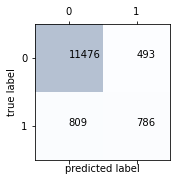

In [70]:
#Plotting a fancier confusion matrix
fig, ax = plt.subplots(figsize = (2.5, 2.5))
ax.matshow(cm, cmap = plt.cm.Blues, alpha = 0.3)

for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(x = j, y = i,
               s = cm[i,j])
        
plt.xlabel('predicted label')
plt.ylabel('true label')
plt.show()

## Analysis

Besides the fact that the neural network got more than 90% accuracy quickly, there is not much to say. The results make perfect sense, since we knew from the beginning that our dataset was imbalanced. 

## Neural Network or Machine Learning algorithm?

The Neural Network outperformed models that implemented a Logistic Regression or a Random Forest. For the question "is it worth it to implement a Neural Network?" to be asked, we should put the NN to the test with the bias problem solved.

Lets define the previous neural network in a function and use it after solving the balance problem.

In [82]:
def Neural_Network():
    #Defining the Neural Network
    model = Sequential()

    model.add(Dense(6,
                   kernel_initializer = "uniform",
                   activation = "relu",
                    input_dim = X_train.shape[1] #Segundo atributo del método
                    #shape, las columnas
                   ))

    model.add(Dense(units = 6,
                   kernel_initializer = "uniform",
                   activation = "relu",
                   ))

    model.add(Dense(units = 1,
                   kernel_initializer = "uniform",
                   activation = "sigmoid"))
    
        #Definimos cómo realizará la red neuronal el aprendizaje
    model.compile(optimizer = RMSprop(learning_rate = 0.01),
                 loss = "binary_crossentropy",
                 metrics = ["accuracy"])
    
    return model

# Upsampling the minority class


In the notebook that addresses the imbalanced data, the best solution was to upsample the minority class, reason why I implement that very same solution here.

In [83]:
from sklearn.utils import resample

In [84]:
#Assign 
minority = data_OHE[data_OHE['y']==1]
majority = data_OHE[data_OHE['y']==0]

In [85]:
#Increase the number of minority samples
minority_up = resample(minority,
                        replace = True,
                        n_samples = len(majority),
                        random_state = 27)

upsampled = pd.concat([majority, minority_up])

#Check the number of samples
upsampled.y.value_counts()

1    39922
0    39922
Name: y, dtype: int64

In [101]:
#It is important to assign the training and testing sets after generating the data with the upsampled/downsized
# minority/majority

X_train, X_test, y_train, y_test = train_test_split(upsampled.drop('y', axis = 1), 
                                                    upsampled['y'],
                                                   test_size = 0.3,
                                                   random_state = 0)

#DON'T FORGET TO SCALE THE TRAINING SETS AGAIN
X_train = sc_X.fit_transform(X_train)
X_test = sc_X.transform(X_test)

### Neural Network, take 2

In [102]:
#Assign the Neural_Network function to the neural variable
neural = Neural_Network()

In [103]:
#Adjust the Neural Network to the training data
neural.fit(X_train, y_train, epochs = 300, batch_size = 128)

Train on 55890 samples
Epoch 1/300
55890/55890 [==============================] - 1s 14us/sample - loss: 0.4261 - accuracy: 0.8286
Epoch 2/300
55890/55890 [==============================] - 0s 7us/sample - loss: 0.3644 - accuracy: 0.8466
Epoch 3/300
55890/55890 [==============================] - 0s 7us/sample - loss: 0.3547 - accuracy: 0.8505
Epoch 4/300
55890/55890 [==============================] - 0s 7us/sample - loss: 0.3501 - accuracy: 0.8522
Epoch 5/300
55890/55890 [==============================] - 0s 7us/sample - loss: 0.3471 - accuracy: 0.8527
Epoch 6/300
55890/55890 [==============================] - 0s 7us/sample - loss: 0.3460 - accuracy: 0.8533
Epoch 7/300
55890/55890 [==============================] - 0s 7us/sample - loss: 0.3442 - accuracy: 0.8559
Epoch 8/300
55890/55890 [==============================] - 0s 7us/sample - loss: 0.3431 - accuracy: 0.8560
Epoch 9/300
55890/55890 [==============================] - 0s 7us/sample - loss: 0.3420 - accuracy: 0.8565
Epoch 10/300


55890/55890 [==============================] - 0s 7us/sample - loss: 0.3209 - accuracy: 0.8677
Epoch 152/300
55890/55890 [==============================] - 0s 7us/sample - loss: 0.3210 - accuracy: 0.8658
Epoch 153/300
55890/55890 [==============================] - 0s 7us/sample - loss: 0.3211 - accuracy: 0.8668
Epoch 154/300
55890/55890 [==============================] - 0s 7us/sample - loss: 0.3208 - accuracy: 0.8673
Epoch 155/300
55890/55890 [==============================] - 0s 7us/sample - loss: 0.3204 - accuracy: 0.8671
Epoch 156/300
55890/55890 [==============================] - 0s 7us/sample - loss: 0.3209 - accuracy: 0.8665
Epoch 157/300
55890/55890 [==============================] - 0s 7us/sample - loss: 0.3209 - accuracy: 0.8665
Epoch 158/300
55890/55890 [==============================] - 0s 7us/sample - loss: 0.3211 - accuracy: 0.8665
Epoch 159/300
55890/55890 [==============================] - 0s 7us/sample - loss: 0.3206 - accuracy: 0.8669
Epoch 160/300
55890/55890 [======

In [104]:
#Make Predictions
y_pred = neural.predict(X_test)

In [105]:
#Use a 0.5 threshold to distinguis between the two class predictions.
y_pred = y_pred>0.5

In [106]:
#Creating the Confusion Matrix
cm = confusion_matrix(y_true = y_test, y_pred = y_pred)

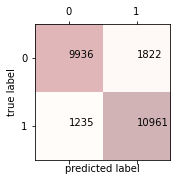

In [112]:
#Plotting a fancier confusion matrix
fig, ax = plt.subplots(figsize = (2.5, 2.5))
ax.matshow(cm, cmap = plt.cm.Reds, alpha = 0.3)

for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(x = j, y = i,
               s = cm[i,j])
        
plt.xlabel('predicted label')
plt.ylabel('true label')
plt.show()

That looks better! With the data fixed, the neural network's bias has been solved. What lies ahead is to optimize the NN's peformance by *playing around* with its hyperparameters.

### Optimizing the Neural Network

Lets tweek the neural network and add one more layer to it, and see what happens.

In [119]:
def Neural_Network_2():
    #Definimos la red neuronal secuencial
    model = Sequential()

    #Layer of Neurons
    model.add(Dense(6,
                   kernel_initializer = "uniform",
                   activation = "relu",
                    input_dim = X_train.shape[1] #Segundo atributo del método
                    #shape, las columnas
                   ))
    
    model.add(Dropout(rate = 0.1))# Turns neurons off and 
                                    #reduces the overfitting risk

    #Layer of Neurons
    model.add(Dense(units = 6,
                   kernel_initializer = "uniform",
                   activation = "relu",
                   ))
    
    model.add(Dropout(rate = 0.1))
    
    #Layer of Neurons
    model.add(Dense(units = 6,
                   kernel_initializer = "uniform",
                   activation = "relu",
                   ))
    
    model.add(Dropout(rate = 0.1))

    #Output Layer
    model.add(Dense(units = 1,
                   kernel_initializer = "uniform",
                   activation = "sigmoid"))
    
        #Definimos cómo realizará la red neuronal el aprendizaje
    model.compile(optimizer = RMSprop(learning_rate = 0.01),
                 loss = "binary_crossentropy",
                 metrics = ["accuracy"])
    
    return model

In [122]:
neural_2 = Neural_Network_2()

In [123]:
neural_2.fit(X_train, y_train, epochs = 300, batch_size = 128)

Train on 55890 samples
Epoch 1/300
55890/55890 [==============================] - 1s 20us/sample - loss: 0.4712 - accuracy: 0.8050
Epoch 2/300
55890/55890 [==============================] - 0s 8us/sample - loss: 0.4395 - accuracy: 0.8140
Epoch 3/300
55890/55890 [==============================] - 0s 8us/sample - loss: 0.4327 - accuracy: 0.8167
Epoch 4/300
55890/55890 [==============================] - 0s 8us/sample - loss: 0.4314 - accuracy: 0.8178
Epoch 5/300
55890/55890 [==============================] - 0s 8us/sample - loss: 0.4299 - accuracy: 0.8180
Epoch 6/300
55890/55890 [==============================] - 0s 8us/sample - loss: 0.4271 - accuracy: 0.8208
Epoch 7/300
55890/55890 [==============================] - 0s 8us/sample - loss: 0.4235 - accuracy: 0.8231
Epoch 8/300
55890/55890 [==============================] - 0s 8us/sample - loss: 0.4244 - accuracy: 0.8222
Epoch 9/300
55890/55890 [==============================] - 0s 8us/sample - loss: 0.4245 - accuracy: 0.8224
Epoch 10/300


55890/55890 [==============================] - 1s 13us/sample - loss: 0.4237 - accuracy: 0.8234
Epoch 152/300
55890/55890 [==============================] - 1s 10us/sample - loss: 0.4221 - accuracy: 0.8252
Epoch 153/300
55890/55890 [==============================] - 1s 13us/sample - loss: 0.4240 - accuracy: 0.8232
Epoch 154/300
55890/55890 [==============================] - 1s 12us/sample - loss: 0.4221 - accuracy: 0.8247
Epoch 155/300
55890/55890 [==============================] - 1s 11us/sample - loss: 0.4225 - accuracy: 0.8246
Epoch 156/300
55890/55890 [==============================] - 1s 10us/sample - loss: 0.4188 - accuracy: 0.8263
Epoch 157/300
55890/55890 [==============================] - 1s 9us/sample - loss: 0.4230 - accuracy: 0.8240
Epoch 158/300
55890/55890 [==============================] - 1s 12us/sample - loss: 0.4212 - accuracy: 0.8250
Epoch 159/300
55890/55890 [==============================] - 1s 14us/sample - loss: 0.4219 - accuracy: 0.8250
Epoch 160/300
55890/55890

55890/55890 [==============================] - 1s 11us/sample - loss: 0.4219 - accuracy: 0.8238
Epoch 300/300
55890/55890 [==============================] - 1s 13us/sample - loss: 0.4218 - accuracy: 0.8240


In [125]:
y_pred = neural_2.predict(X_test)
y_pred = y_pred>0.5

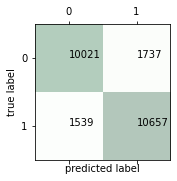

In [126]:
cm = confusion_matrix(y_true = y_test, y_pred = y_pred)

#Plotting a fancier confusion matrix
fig, ax = plt.subplots(figsize = (2.5, 2.5))
ax.matshow(cm, cmap = plt.cm.Greens, alpha = 0.3)

for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(x = j, y = i,
               s = cm[i,j])
        
plt.xlabel('predicted label')
plt.ylabel('true label')
plt.show()

In [127]:
neural_2.evaluate(X_test, y_test)

23954/23954 [==============================] - 0s 20us/sample - loss: 0.3728 - accuracy: 0.8632


[0.372764693801885, 0.86323786]

In [128]:
neural.evaluate(X_test, y_test)

23954/23954 [==============================] - 0s 20us/sample - loss: 0.3088 - accuracy: 0.8724


[0.30876632127467624, 0.8723804]

The NN did not perform that well this time around. The extra layer is not really worth it, so I will optimize the **Neural_Network()** function.

# Neural Network Hyperparameter's Optimization

To optimize the neural network I am going to use the *GidSearchCV* function from *sklearn*, which will be provided with a dictionary containing the several parameters to optimize with a pair of values to iterate with.

In [118]:
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

Lets define the neural network once more, leaving this time some parameters to be defined by the dictionary that will be passed to the *GridSearchCV* function.

In [138]:
def Neural(optimizer, learning_rate):
    classifier = Sequential()
    classifier.add(Dense(units = 6, 
                         kernel_initializer = "uniform",
                         activation = "relu",
                         input_dim = X_train.shape[1]))
    
    classifier.add(Dense(units = 6, kernel_initializer = "uniform", 
                         activation = "relu"))
    
    classifier.add(Dense(units = 1, kernel_initializer = "uniform",  
                         activation = "sigmoid"))
    
    classifier.compile(optimizer = optimizer(learning_rate),
                       loss = "binary_crossentropy", 
                       metrics = ["accuracy"])
    return classifier

In [139]:
classifier = KerasClassifier(build_fn = Neural)

In [140]:
#Dictionary with the parameters to optimize and the values to try out.
parameters = {
    'batch_size' : [25, 32],
    'nb_epoch' : [100, 300],
    'optimizer': [Adam, RMSprop],
    'learning_rate': [0.01, 0.03]
}

In [141]:
grid_search = GridSearchCV(estimator = classifier, 
                           param_grid = parameters, 
                           scoring = 'accuracy', 
                           cv = 10)

In [142]:
grid_search = grid_search.fit(X_train, y_train)

Train on 50301 samples
50301/50301 [==============================] - 2s 41us/sample - loss: 0.3711 - accuracy: 0.8392
Train on 50301 samples
50301/50301 [==============================] - 2s 42us/sample - loss: 0.3720 - accuracy: 0.8389
Train on 50301 samples
50301/50301 [==============================] - 2s 43us/sample - loss: 0.3789 - accuracy: 0.8386
Train on 50301 samples
50301/50301 [==============================] - 2s 42us/sample - loss: 0.3702 - accuracy: 0.8403
Train on 50301 samples
50301/50301 [==============================] - 2s 42us/sample - loss: 0.3693 - accuracy: 0.8403
Train on 50301 samples
50301/50301 [==============================] - 2s 45us/sample - loss: 0.3777 - accuracy: 0.8373
Train on 50301 samples
50301/50301 [==============================] - 2s 47us/sample - loss: 0.3695 - accuracy: 0.8380
Train on 50301 samples
50301/50301 [==============================] - 3s 55us/sample - loss: 0.3751 - accuracy: 0.8394
Train on 50301 samples
50301/50301 [============

50301/50301 [==============================] - 2s 39us/sample - loss: 0.3760 - accuracy: 0.8397
Train on 50301 samples
50301/50301 [==============================] - 2s 38us/sample - loss: 0.3765 - accuracy: 0.8385
Train on 50301 samples
50301/50301 [==============================] - 2s 39us/sample - loss: 0.3781 - accuracy: 0.8409
Train on 50301 samples
50301/50301 [==============================] - 2s 46us/sample - loss: 0.3742 - accuracy: 0.8429
Train on 50301 samples
50301/50301 [==============================] - 2s 36us/sample - loss: 0.3748 - accuracy: 0.8374
Train on 50301 samples
50301/50301 [==============================] - 2s 36us/sample - loss: 0.4046 - accuracy: 0.8267
Train on 50301 samples
50301/50301 [==============================] - 2s 39us/sample - loss: 0.3766 - accuracy: 0.8388
Train on 50301 samples
50301/50301 [==============================] - 2s 36us/sample - loss: 0.3771 - accuracy: 0.8377
Train on 50301 samples
50301/50301 [==============================] - 2

In [143]:
best_parameters = grid_search.best_params_
best_accuracy = grid_search.best_score_

print('The best parameters are: ', best_parameters)
print('Best Score of the Neural Network: ', best_accuracy)

The best parameters are:  {'batch_size': 32, 'learning_rate': 0.01, 'nb_epoch': 300, 'optimizer': <class 'tensorflow.python.keras.optimizer_v2.rmsprop.RMSprop'>}
Best Score of the Neural Network:  0.8518876364286992


# Conclusion

The Neural Network managed to obtain good results in classifying the two classes after upsampling the minority class, which is also required for a "simpler" algorithm, and training it.

**However...**

With this notebook I have built a simple Two-Class Neural Network and got it, by optimizing the parameters, to an 86% accuracy. Nevertheless, in the notebook *Imbalanced Data* the *Random Forest* algorithm worked better, with the scores:

- Accuracy: 96.6%
- Recall: 99.75%
- f1 Score: 96.75%

It can be seen that the *Random Forest* outperformed the Neural Network by 10% in *accuracy*. So, to train a Neural Network might not be worth it for every problem due to:

- A neural network requires lots of data to be properly trained.
- NNs require long training time to get to highly accurate predictions.


- Simpler algorithms such as a Random Forest can outperform them with much less training samples and time.